# SEASONAL AND SOCIOLOGICAL IMPACTS ON KIVA MICROLENDING

#
Hypothosis - you can detect trends in loan sizes, amounts, and regions based on seasonality and sociology
Based on that, you can anticipate demand and ready funding sources in advanced of increased demand

in the end, want to look at things like:
    - IS THERE A RELATIONSHIP BETWEEN PERCENTAGE BELOW POVERTY LINE AND THE REASONS FOR LOANS BEING TAKEN OUT (LOOK AT ACTIVITY COLUMN ON LOANS_ORIGINAL AND ALSO IMPORT LOAN_THEMES DATASET)
    - IN A GIVEN COUNTRY, ARE CERTAIN LOAN THEMES COMMON DURING SOME MONTHS, AND UNCOMMON DURING OTHERS? SIMILARLY, IS THERE A CYCLICAL NATURE TO AVERAGE LOAN SIZE GIVEN THE SAME THEME AND COUNTRY, BUT OVER DIFFERENT MONTHS?
        - HYPOTHETICAL FUTURE INVESTIGATION COULD INCLUDE THE AMOUNT OF TIME BETWEEN POSTED_TIME AND FUNDED_TIME WITH AN EYE TOWARD ANTICIPATING SEASONAL DEMAND AND READYING FUNDERS IN ADVANCE OF INCREASED DEMAND. (THIS SEEMS UNLIKELY GIVEN THE PROBLEMS WITH FORMATS OF DATE FIELDS)

In [426]:
import pandas as pd
import numpy as np
import matplotlib as plt
# import re # regexp replace module, not needed
import datetime
from datetime import datetime
# import requests
%matplotlib inline

In [427]:
loans_all = pd.read_csv('kiva_loans.csv')

In [428]:
loans_all.shape

(552642, 20)

# create a subset of data using ILOC
this was used for testing/development purposes due to the size of the original data (671205 x 20)

In [184]:
# loans = loans_all.iloc[0:100000,0:20]
# loans.shape

(100000, 20)

In [429]:
loans_all.head(1)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,1080148,250,250,Services,Services,purchase leather for my business using ksh 20000.,KE,Kenya,NaN,KES,NaN,2014-01,2014-01,2014-01,4,6,NaN,female,irregular,1/1/14


# convert columns from strings to datetimes
three date columns showed as strings, but when using the apply function, it said the columns were float, so they were not subscriptable
        __def year_mo(value):
        __return value[:7]
        __loans_original['disbursed_time'] = loans_original['disbursed_time'].apply(year_mo)

1. cleaned date columns in Excel
2. re-imported data
3. used the to_datetime method from datetime module converts strings into datetime objects
4. when extracting the month using datetime, couldn't get two digits, so unsortable

In [ ]:
# # convert columns from strings to datetimes
# pd.to_datetime(loans_original['posted_time'])
# pd.to_datetime(loans_original['disbursed_time'])
# pd.to_datetime(loans_original['funded_time'])

In [430]:
# rename columns to reflect months rather than times
loans_all = loans_all.rename(columns={'posted_time':'posted_month','disbursed_time':'disbursed_month','funded_time':'funded_month'})

# LOANS BY MONTH

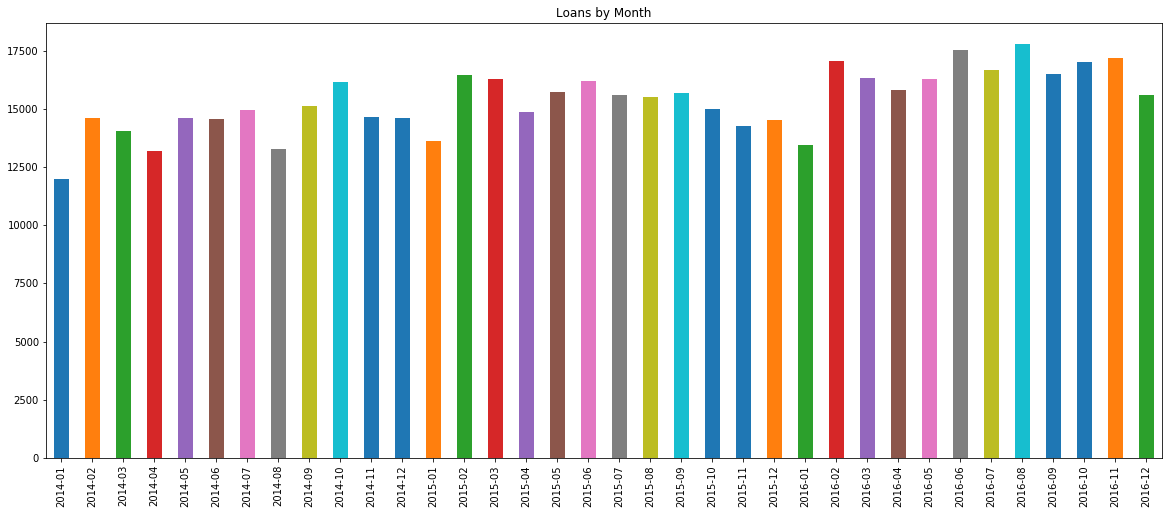

In [431]:
loans_all['disbursed_month'].value_counts().sort_index().plot(kind='bar',figsize=(20,8),title='Loans by Month')

## LOANS BY COUNTRY, TOP 20

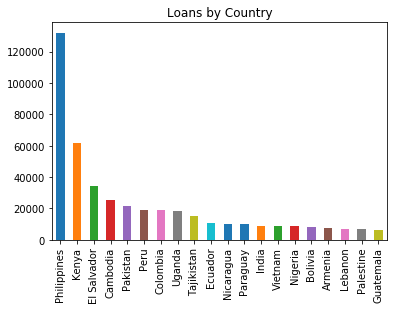

In [432]:
loans_all['country'].value_counts().head(20).plot(kind='bar', title = 'Loans by Country')


# COUNTRY DATA


In [433]:
country_stats = pd.read_csv('country_stats.csv')

In [434]:
country_stats.columns

Index(['country_name', 'country_code', 'country_code3', 'continent', 'region',
       'population', 'population_below_poverty_line', 'hdi', 'life_expectancy',
       'expected_years_of_schooling', 'mean_years_of_schooling', 'gni',
       'kiva_country_name'],
      dtype='object')

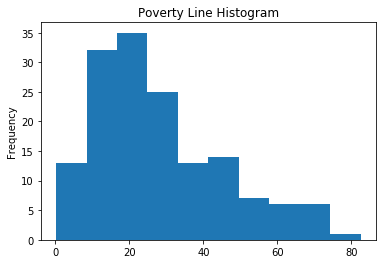

In [463]:
# make sure you can work with the country data
country_stats['population_below_poverty_line'].plot(kind='hist',bins=10,title='Poverty Line Histogram')


# LOAN THEME DATA


In [440]:
loan_themes = pd.read_csv('loan_theme_ids.csv')

In [447]:
# show that theme data can be worked with
loan_themes.groupby(['Loan Theme Type']).count().head(2)

,id,Loan Theme ID,Partner ID
Loan Theme Type,,,
Agricultural Equipment,278,278,278
Agricultural Infrastructure,51,51,51



# COMBINE LOAN AND THEME DATA


In [441]:
loans_w_themes = pd.merge(loans_all,loan_themes,how='inner',left_on='id',right_on='id')

In [443]:
loans_w_themes.shape

(552642, 23)


# COMBINE LOAN, THEME, AND COUNTRY DATA INTO ONE DATAFRAME


In [454]:
country_stats.columns

Index(['country_name', 'country_code', 'country_code3', 'continent', 'region',
       'population', 'population_below_poverty_line', 'hdi', 'life_expectancy',
       'expected_years_of_schooling', 'mean_years_of_schooling', 'gni',
       'kiva_country_name'],
      dtype='object')

In [453]:
loans_w_themes.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_month', 'disbursed_month', 'funded_month', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date', 'Loan Theme ID', 'Loan Theme Type', 'Partner ID'],
      dtype='object')

In [455]:
final_loan_data = pd.merge(loans_w_themes,country_stats,how='inner',left_on='country',right_on='kiva_country_name')

In [456]:
final_loan_data.shape

(552622, 36)


# START GRAPHING DATA POINTS


In [540]:
# get average loan amount by country
loan_counts = final_loan_data.groupby('country',as_index=False)['funded_amount'].count()
loan_amounts = final_loan_data.groupby('country',as_index=False)['funded_amount'].sum()

aggregates = pd.merge(loan_counts,loan_amounts, how='inner', left_on='country',right_on='country')
aggregates = aggregates.rename(columns={'funded_amount_x':'loan_count','funded_amount_y':'funded_amount'})

aggregates['average_amount'] = aggregates['funded_amount']/aggregates['loan_count']

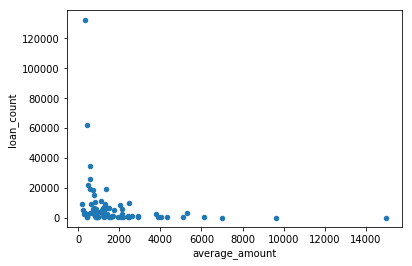

In [549]:
aggregates.plot(kind='scatter',x='average_amount',y='loan_count')

In [546]:
# get average loan amount by country, by month
loan_counts_new = final_loan_data.groupby(['country','disbursed_month'],as_index=False)['funded_amount'].count()
loan_amounts_new = final_loan_data.groupby(['country','disbursed_month'],as_index=False)['funded_amount'].sum()

aggregates_new = pd.merge(loan_counts_new,loan_amounts_new, how='inner', left_on=['country','disbursed_month'],right_on=['country','disbursed_month'])
aggregates_new = aggregates_new.rename(columns={'funded_amount_x':'loan_count','funded_amount_y':'funded_amount'})

aggregates_new['average_amount'] = aggregates_new['funded_amount']/aggregates_new['loan_count']


# plot loan amount by month for given country - eventually put into a function with user input

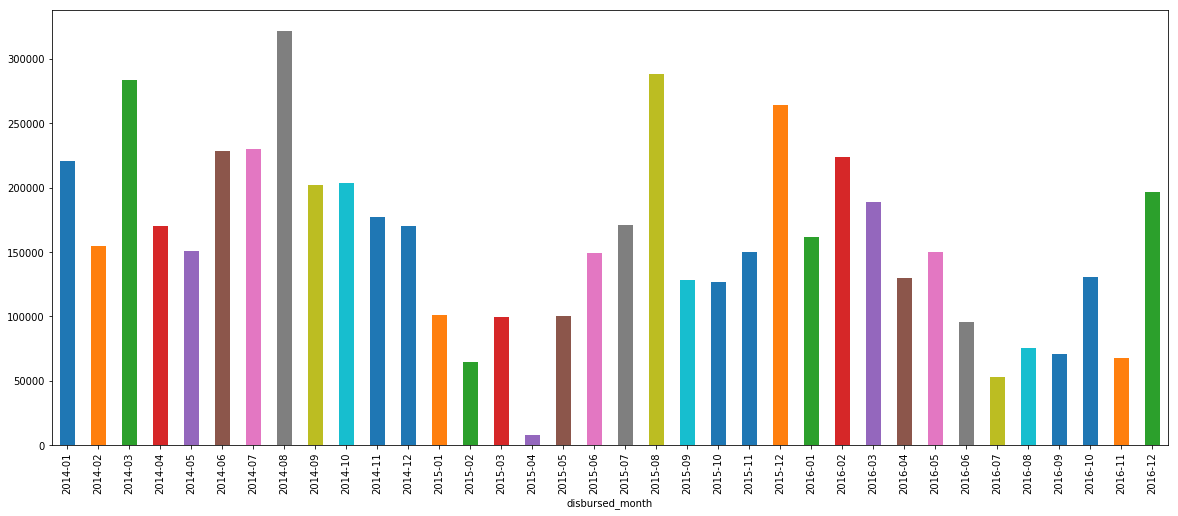

In [531]:
india = aggregates_new[aggregates_new.country=='India']

india.groupby(['disbursed_month'])['funded_amount'].sum().plot(kind='bar',figsize=(20,8))

In [560]:
final_loan_data.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code_x', 'country', 'region_x', 'currency', 'partner_id',
       'posted_month', 'disbursed_month', 'funded_month', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date', 'Loan Theme ID', 'Loan Theme Type', 'Partner ID',
       'country_name', 'country_code_y', 'country_code3', 'continent',
       'region_y', 'population', 'population_below_poverty_line', 'hdi',
       'life_expectancy', 'expected_years_of_schooling',
       'mean_years_of_schooling', 'gni', 'kiva_country_name'],
      dtype='object')

In [572]:
Egypt = final_loan_data[final_loan_data.country=='Egypt']

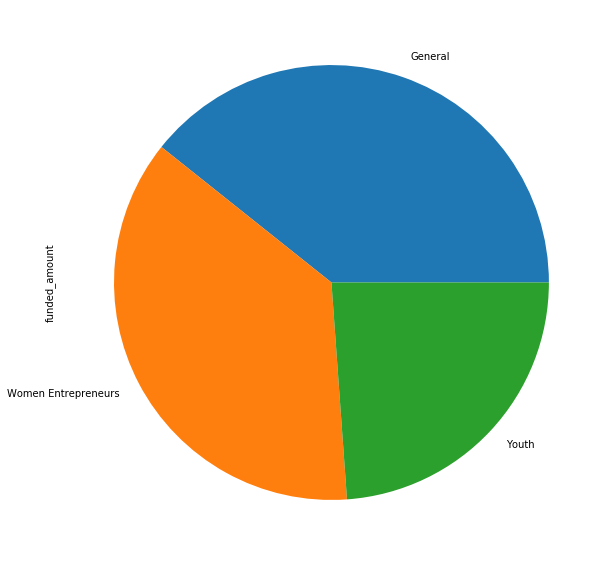

In [573]:
Egypt.groupby(['Loan Theme Type'])['funded_amount'].sum().plot(kind='pie',figsize=(10,10))

In [574]:
Egypt.groupby(['Loan Theme Type'])['funded_amount'].sum()

Loan Theme Type
General                349300
Women Entrepreneurs    327600
Youth                  212125
Name: funded_amount, dtype: int64

In [580]:
Lebanon = final_loan_data[final_loan_data.country=='Lebanon']

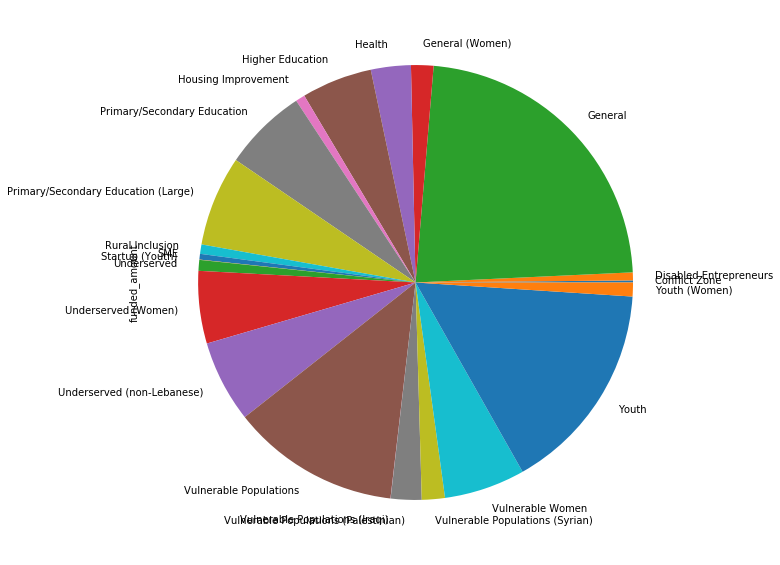

In [581]:
Lebanon.groupby(['Loan Theme Type'])['funded_amount'].sum().plot(kind='pie',figsize=(10,10))

# FOLLOWUPS:
Sociology seems to be more of a predictor than seasonality

Create a function for returning specific country data